In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM


import warnings # Supress warnings 
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving S4248SM144NCEN.csv to S4248SM144NCEN.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['S4248SM144NCEN.csv']), sep=',')
df.head()

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [ ]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 1992-01-01 to 2019-04-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   S4248SM144NCEN  328 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [ ]:
df.columns=['Sales']
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


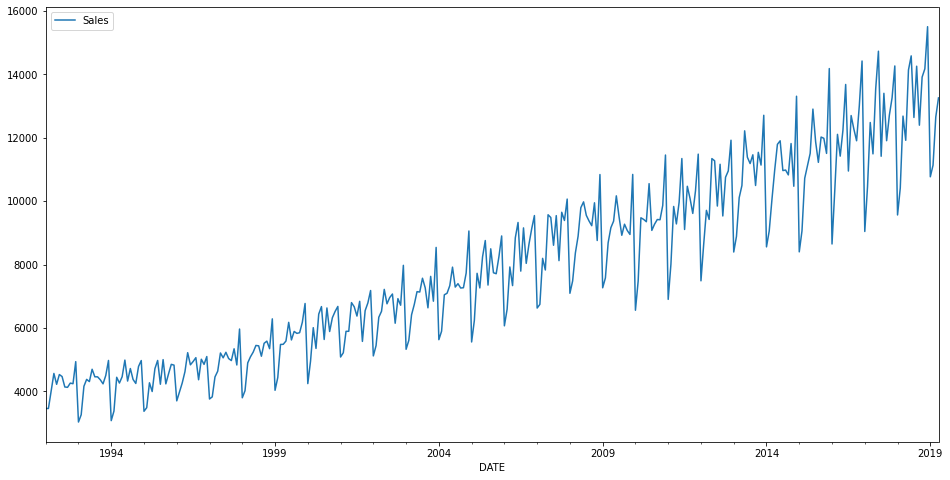

In [ ]:
df.plot(figsize=(16,8))


## Seasonal Decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result= seasonal_decompose(df['Sales'])

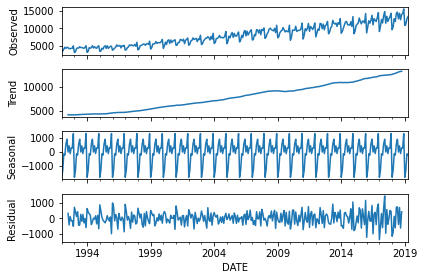

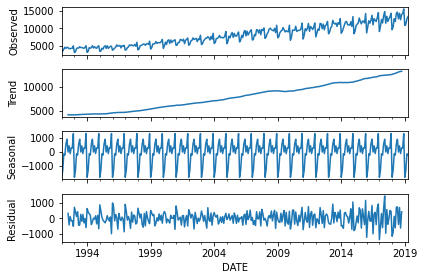

In [ ]:
result.plot()

In [ ]:
len(df)

328

In [ ]:
## Train Test Data
train = df.iloc[:316]               ## 96%
test= df.iloc[316:]                 ## 4%

print("train:",train.shape, "&", "test:", test.shape)

train: (316, 1) & test: (12, 1)


In [ ]:
test

,Sales
DATE,
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10768


## Normalisasi

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
## apply scaler ke data train dan test
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test) 
scaled_train[:10]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ],
       [0.12804513],
       [0.12266006],
       [0.09453799],
       [0.09359774],
       [0.10496624]])

In [ ]:
len(scaled_train)

316

# Building Model

In [ ]:
n_input = 12
n_feature = 1

train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input, batch_size=1)

In [ ]:
train_generator

In [ ]:
model = Sequential()

model.add(LSTM(128,activation = 'relu', input_shape= (n_input, n_feature), return_sequences=True))          ## input
model.add(LSTM(128, activation='relu', return_sequences=True))                                              ## first hidden layer
model.add(LSTM(128, activation='relu', return_sequences=False))                                             ## second hidden layer
model.add(Dense(1))                                                                                         ## output layer
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 329,857
Trainable params: 329,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## fitting model with generator
model.fit_generator(train_generator,epochs= 50)

Epoch 1/50
304/304 [==============================] - 30s 16ms/step - loss: 0.0497
Epoch 2/50
304/304 [==============================] - 5s 16ms/step - loss: 0.0118
Epoch 3/50
304/304 [==============================] - 5s 17ms/step - loss: 0.0090
Epoch 4/50
304/304 [==============================] - 5s 16ms/step - loss: 0.0120
Epoch 5/50
304/304 [==============================] - 5s 16ms/step - loss: 0.0074
Epoch 6/50
304/304 [==============================] - 5s 16ms/step - loss: 0.0066
Epoch 7/50
304/304 [==============================] - 5s 16ms/step - loss: 0.0055
Epoch 8/50
304/304 [==============================] - 5s 16ms/step - loss: 0.0039
Epoch 9/50
304/304 [==============================] - 5s 16ms/step - loss: 0.0035
Epoch 10/50
304/304 [==============================] - 5s 16ms/step - loss: 0.0033
Epoch 11/50
304/304 [==============================] - 5s 16ms/step - loss: 0.0031
Epoch 12/50
304/304 [==============================] - 5s 16ms/step - loss: 0.0021
Epoch 13/50


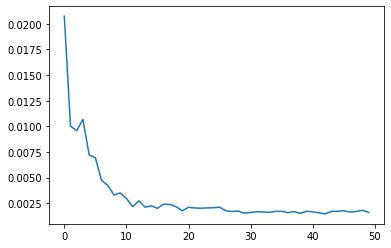

In [ ]:
## score result (loss function)
my_loss= model.history.history['loss']
plt.plot(range(len(my_loss)),my_loss)

stabil di 0.002 an

# Prediction

In [ ]:
first_eval_batch = scaled_train[-12:]               ## ambil 12 terakhir
first_eval_batch

array([[0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ],
       [0.63116506],
       [0.82502778],
       [0.75972305]])

In [ ]:
# reshape
first_eval_batch = first_eval_batch.reshape((1,n_input,n_feature))
first_eval_batch

array([[[0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ],
        [0.63116506],
        [0.82502778],
        [0.75972305]]])

In [ ]:
model.predict(first_eval_batch)                 ## prediction

array([[1.0346451]], dtype=float32)

In [ ]:
#holding my predictions
test_predictions = []


# last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]

# reshape this to the format RNN wants (same format as TimeseriesGeneration)
current_batch = first_eval_batch.reshape((1,n_input,n_feature))


array([[[0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ],
        [0.63116506],
        [0.82502778],
        [0.75972305]]])

In [ ]:
for i in range(len(test)):
    
    # One timestep ahead of historical 12 points
    current_pred = model.predict(current_batch)[0]
    
    #store that prediction
    test_predictions.append(current_pred)
    
    # UPDATE current batch o include prediction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis= 1)
test_predictions

[array([1.0346451], dtype=float32),
 array([1.1064687], dtype=float32),
 array([0.84613794], dtype=float32),
 array([0.9929849], dtype=float32),
 array([0.8731102], dtype=float32),
 array([0.94912624], dtype=float32),
 array([1.0061073], dtype=float32),
 array([1.065613], dtype=float32),
 array([0.6466239], dtype=float32),
 array([0.76119035], dtype=float32),
 array([0.9295386], dtype=float32),
 array([0.94423205], dtype=float32)]

In [ ]:
## inverse dari normalisasi
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[15135.31279755],
       [15975.57705832],
       [12929.9677704 ],
       [14647.93023908],
       [13245.51593888],
       [14134.82792377],
       [14801.44965744],
       [15497.6068542 ],
       [10595.85311693],
       [11936.16596109],
       [13905.67217028],
       [14077.57071322]])

In [ ]:
test['Predictions'] =true_predictions
test

,Sales,Predictions
DATE,,
2018-05-01,14138,15135.312798
2018-06-01,14583,15975.577058
2018-07-01,12640,12929.967770
2018-08-01,14257,14647.930239
2018-09-01,12396,13245.515939
2018-10-01,13914,14134.827924
2018-11-01,14174,14801.449657
2018-12-01,15504,15497.606854
2019-01-01,10768,10595.853117


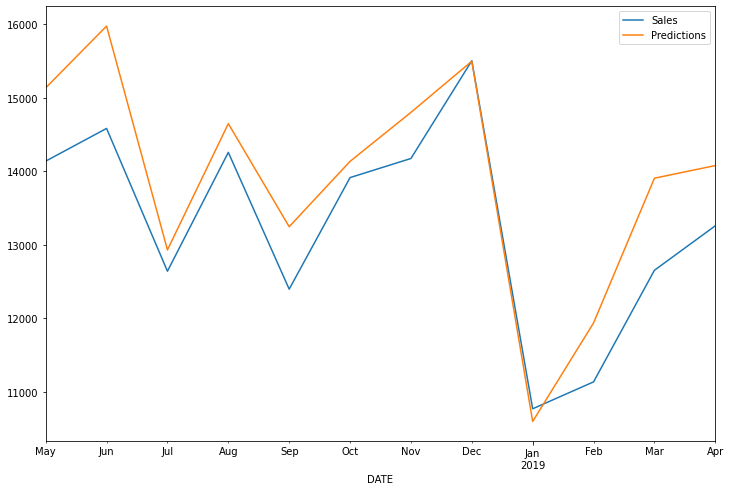

In [ ]:
test.plot(figsize=(12,8))
